<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Convolutional Neural Networks with TensorFlow

_Authors: Richard Harris (SF)_

<a id="learning-objectives"></a>
### Learning Objectives
- Understand what improvements convolutional neural nets make more image data.
- Apply CNN to the MIST Digits dataset
- Introduce DropOut as a regularization mechanism in neural nets

### Lesson Guide
- [Introduction to Convolutional Neural Nets](#introduction-to-convolutional-neural-nets)
	- [Convolution](#convolution)
	- [Non-linearity](#non-linearity)
	- [Pooling / Subsampling](#pooling--subsampling)
- [Import the MNIST  digits dataset](#import-the-mnist--digits-dataset)
- [Create a Convolutional Neural Network](#create-a-convolutional-neural-netwrok)
	- [Training parameters](#training-parameters)
	- [Create input tensors](#create-input-tensors)
	- [Define convolution and pooling layers](#define-convolution-and-pooling-layers)
	- [Define the convolutional neural network](#define-the-convolutional-neural-network)
	- [Define network paramters that will be fit](#define-network-paramters-that-will-be-fit)
	- [Create loss function for classifying digits](#create-loss-function-for-classifying-digits)
	- [Train the CNN](#train-the-cnn)
- [The whole process in one step](#the-whole-process-in-one-step)
- [Adding convolution and pooling layers](#adding-convolution-and-pooling-layers)


In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

<a id="introduction-to-convolutional-neural-nets"></a>
## Introduction to Convolutional Neural Nets
---

This is an excellent article on Convolutional Neural Nets: https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

In summary:
Convolutional neural networks are used predominately in the image recognition field and tweak the first part of the typical multi-layer perceptron. The changes are:

1. We add convolution layers
2. We introduce Non-Linearity through ReLU activation functions
3. We use Pooling or Sub-samping

<a id="convolution"></a>
### Convolution

Convolution involves creating a smaller, transformed image by sliding a smaller frame (such as a 3x3 matrix) over the larger image and applying a transformation. Depending on the values in the sliding matrix, this has the effects of sharpening, blurring, or finding edges in an image.

<a id="non-linearity"></a>
### Non-linearity
We want to be able to model non-linearity with the network. There are several activation functions that could work, but it's typical to use ReLu because it is fast to computes and avoids the vanishing gradient problem.

<a id="pooling--subsampling"></a>
### Pooling / Subsampling
While our 28x28 pixel data is not extremely large, passing all 784 pixels through the network is burdensome. Pooling is a way to systematically downsample our image into a lower resolution image. This helps reduce the complexity of the network as we pass information from layer to layer.

<a id="import-the-mnist--digits-dataset"></a>
## Import the MNIST  digits dataset
---

For this example (because it's easy and at hand) we'll be using the [mnist](http://yann.lecun.com/exdb/mnist/) handwritten digit dataset again.

The goal is to categorize 28x28 px images of written numbers as 0-9.

In [4]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<a id="create-a-convolutional-neural-netwrok"></a>
## Create a Convolutional Neural Network
---

<a id="training-parameters"></a>
### Training parameters

We want to set up a couple of parameters, which include:

- **learning_rate**: how quickly or slowly the model learns
- **training_iters**: (or epochs) how many times we run the data through the network to train it
- **batch_size**: the number of rows we send into the CNN in a given set
- **display_step**: how often we print an update to STDOUT
- **dropout**: The percent of neurons that we will leave in the network while dropping the others at random

In [19]:
learning_rate = 0.01
training_iters = 5000
batch_size = 128
display_step = 2
n_input = 784 # we unravel the 28x28 image into a row of 784 entries
n_classes = 10 # the end state is the likelihood of falling into 1 of 10 classes
dropout = 0.75 # likelihood that a given entity will be kept

<a id="create-input-tensors"></a>
### Create input tensors

Next, we want to set up the tensors for our input and output states. 

In [7]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

<a id="define-convolution-and-pooling-layers"></a>
### Define convolution and pooling layers

Next we want to set up a convolution layer and a pooling layer using some boilerplate code

We will also add a `dropout`. A dropout parameter drops out nodes with a certain likelihood, which ensures that we don't overfit too much to the data itself. More info [here](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout).

Particularly in CNNs, there can be quite a chance of overfitting, using dropout will help us control overfitting.

In [9]:
def conv2d(x, W, b, strides=1):
    # Takes in an x, a set of weights, strides over the image, and with 0 pads around the border
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME') 
    # Add in a bias term
    x = tf.nn.bias_add(x, b)
    # ReLU activation
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # Takes the max value over the window to reduce size
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
            strides=[1, k, k, 1],
            padding='SAME')

<a id="define-the-convolutional-neural-network"></a>
### Define the convolutional neural network

Now, let's address the shape of our convolutional neural network. Given the basic network, it's going to involve the following:

1. 1 Convolution plus Pooling Layer
2. 1 Fully Connected Network

In [10]:
def conv_net(x, weights, biases, dropout):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    
    fc1 = tf.reshape(conv1, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])

    fc1 = tf.nn.dropout(fc1, dropout)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

<a id="define-network-paramters-that-will-be-fit"></a>
### Define network paramters that will be fit

In [11]:
weights = {
        'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
        'wd1': tf.Variable(tf.random_normal([7*7*128, 1024])),
        'out': tf.Variable(tf.random_normal([1024, n_classes]))
        }

biases = {
        'bc1': tf.Variable(tf.random_normal([32])),
        'bd1': tf.Variable(tf.random_normal([1024])),
        'out': tf.Variable(tf.random_normal([n_classes]))
        }

<a id="create-loss-function-for-classifying-digits"></a>
### Create loss function for classifying digits

Now that we have the network set up, we can set up our function to predict, our loss function, and how we optimize it. 

**Loss function**

We will use a standard cross_entropy measure that is frequently chosen for classification problems in neural nets.

**Optimizer**

This time we're going to use something called `AdamOptimizer`, which uses a _moving average_ of estimates, which allows it to keep [inertia](https://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow) (so, if things have been getting better it's going to zoom in that direction, versus plodding carefully forward)

In [13]:
pred = conv_net(x, weights, biases, keep_prob)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Finally, we create a couple of helpful functions which let us figure out if the prediction was correct or not and reduce a bunch of correct or incorrect predictions to an average set of accuracy.

In [14]:
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

<a id="train-the-cnn"></a>
### Train the CNN

Now to fit our CNN! We start the tensorflow session, batch each set of MNIST data, and optimize the network using the learning rate.

The second set of shows how well the overall network is performing.

Iteration 256 and Minibatch Loss=  13583.556641 and Training Acc.=  0.25000
Iteration 512 and Minibatch Loss=  9369.873047 and Training Acc.=  0.46875
Iteration 768 and Minibatch Loss=  6929.459961 and Training Acc.=  0.36719
Iteration 1024 and Minibatch Loss=  7711.730469 and Training Acc.=  0.40625
Iteration 1280 and Minibatch Loss=  4412.024902 and Training Acc.=  0.52344
Iteration 1536 and Minibatch Loss=  2658.328613 and Training Acc.=  0.57812
Iteration 1792 and Minibatch Loss=  2091.237305 and Training Acc.=  0.67188
Iteration 2048 and Minibatch Loss=  3270.633545 and Training Acc.=  0.49219
Iteration 2304 and Minibatch Loss=  1886.576538 and Training Acc.=  0.75781
Iteration 2560 and Minibatch Loss=  592.411438 and Training Acc.=  0.80469
Iteration 2816 and Minibatch Loss=  1057.526367 and Training Acc.=  0.75000
Iteration 3072 and Minibatch Loss=  1170.883911 and Training Acc.=  0.78125
Iteration 3328 and Minibatch Loss=  1187.114136 and Training Acc.=  0.79688
Iteration 3584 

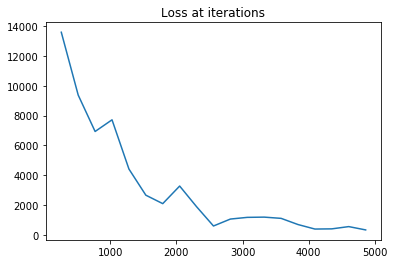

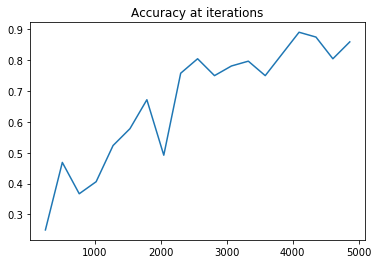

In [15]:
accuracy_list = []

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})

        if step % display_step == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                y: batch_y, keep_prob: 1.})

            print "Iteration", str(step*batch_size), "and Minibatch Loss= ", \
                    "{:.6f}".format(loss), "and Training Acc.= ", \
                    "{:.5f}".format(acc)
            
            accuracy_list.append((step*batch_size, loss, acc))
        step += 1

    print "Test accuracy:", \
            sess.run(accuracy, feed_dict={x: mnist.test.images,
                y: mnist.test.labels,
                keep_prob: 1.})

    y_actual = tf.argmax(y, 1).eval(feed_dict={y:mnist.test.labels})
    y_pred = tf.argmax(pred, 1).eval(feed_dict={x:mnist.test.images, keep_prob:1.})

    print pd.DataFrame(confusion_matrix(y_actual, y_pred),
            index=['Actually %s' % x for x in range(0, 10)],
            columns=['Predicted %s' %  x for x in range(0, 10)])

    print classification_report(y_actual, y_pred)
    
    plt.plot([x[0] for x in accuracy_list],
         [x[1] for x in accuracy_list],
        )
    plt.title('Loss at iterations')
    plt.show()

    plt.plot([x[0] for x in accuracy_list],
             [x[2] for x in accuracy_list],
            )
    plt.title('Accuracy at iterations')
    plt.show()


Looks like we do a good job. The network has some trouble predicting 3, 5, and 8. Do we get better with more iterations? 

<a id="the-whole-process-in-one-step"></a>
## The whole process in one step
---

Let's retrain everything in one go.

Iteration 256 and Minibatch Loss=  10770.707031 and Training Acc.=  0.34375
Iteration 512 and Minibatch Loss=  13410.317383 and Training Acc.=  0.37500
Iteration 768 and Minibatch Loss=  9418.032227 and Training Acc.=  0.50000
Iteration 1024 and Minibatch Loss=  7561.281250 and Training Acc.=  0.53125
Iteration 1280 and Minibatch Loss=  5530.550781 and Training Acc.=  0.44531
Iteration 1536 and Minibatch Loss=  1243.757080 and Training Acc.=  0.67969
Iteration 1792 and Minibatch Loss=  2073.760254 and Training Acc.=  0.65625
Iteration 2048 and Minibatch Loss=  2300.981934 and Training Acc.=  0.60938
Iteration 2304 and Minibatch Loss=  1396.803955 and Training Acc.=  0.71094
Iteration 2560 and Minibatch Loss=  861.369263 and Training Acc.=  0.81250
Iteration 2816 and Minibatch Loss=  955.835754 and Training Acc.=  0.75000
Iteration 3072 and Minibatch Loss=  614.272583 and Training Acc.=  0.85156
Iteration 3328 and Minibatch Loss=  452.372681 and Training Acc.=  0.82812
Iteration 3584 an

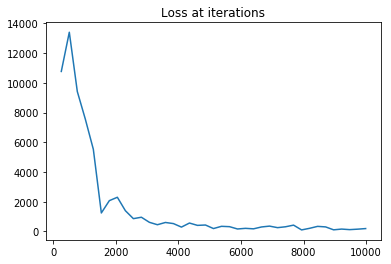

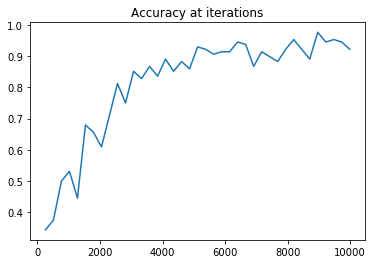

In [16]:
learning_rate = 0.01
training_iters = 10000 # now we change the number of epochs
batch_size = 128
display_step = 2

n_input = 784 # we unravel the 28x28 image into a row of 784 entries
n_classes = 10 # the end state is the likelihood of falling into 1 of 10 classes
dropout = 0.75 # likelihood that a given entity will be kept

x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

def conv2d(x, W, b, strides=1):
    # Takes in an x, a set of weights, strides over the image, and with 0 pads around the border
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME') 
    # Add in a bias term
    x = tf.nn.bias_add(x, b)
    # ReLU activation
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # Takes the max value over the window to reduce size
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
            strides=[1, k, k, 1],
            padding='SAME')

def conv_net(x, weights, biases, dropout):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    
    fc1 = tf.reshape(conv1, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])

    fc1 = tf.nn.dropout(fc1, dropout)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

weights = {
        'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
        'wd1': tf.Variable(tf.random_normal([7*7*128, 1024])),
        'out': tf.Variable(tf.random_normal([1024, n_classes]))
        }

biases = {
        'bc1': tf.Variable(tf.random_normal([32])),
        'bd1': tf.Variable(tf.random_normal([1024])),
        'out': tf.Variable(tf.random_normal([n_classes]))
        }


pred = conv_net(x, weights, biases, keep_prob)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

accuracy_list = []

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})

        if step % display_step == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                y: batch_y, keep_prob: 1.})

            print "Iteration", str(step*batch_size), "and Minibatch Loss= ", \
                    "{:.6f}".format(loss), "and Training Acc.= ", \
                    "{:.5f}".format(acc)
            
            accuracy_list.append((step*batch_size, loss, acc))
        step += 1

    print "Test accuracy:", \
            sess.run(accuracy, feed_dict={x: mnist.test.images,
                y: mnist.test.labels,
                keep_prob: 1.})

    y_actual = tf.argmax(y, 1).eval(feed_dict={y:mnist.test.labels})
    y_pred = tf.argmax(pred, 1).eval(feed_dict={x:mnist.test.images, keep_prob:1.})

    print pd.DataFrame(confusion_matrix(y_actual, y_pred),
            index=['Actually %s' % x for x in range(0, 10)],
            columns=['Predicted %s' %  x for x in range(0, 10)])

    print classification_report(y_actual, y_pred)
    
    plt.plot([x[0] for x in accuracy_list],
         [x[1] for x in accuracy_list],
        )
    plt.title('Loss at iterations')
    plt.show()

    plt.plot([x[0] for x in accuracy_list],
             [x[2] for x in accuracy_list],
            )
    plt.title('Accuracy at iterations')
    plt.show()


Great, even better, but we are hitting diminishing returns. Let's add in a second convolution plus pooling layer. We'll reuse all the code from above, but change the definition of `conv_net`.

<a id="adding-convolution-and-pooling-layers"></a>
## Adding convolution and pooling layers
---

Iteration 256 and Minibatch Loss=  240960.250000 and Training Acc.=  0.27344
Iteration 512 and Minibatch Loss=  171072.062500 and Training Acc.=  0.25000
Iteration 768 and Minibatch Loss=  82632.796875 and Training Acc.=  0.34375
Iteration 1024 and Minibatch Loss=  66878.898438 and Training Acc.=  0.48438
Iteration 1280 and Minibatch Loss=  44365.820312 and Training Acc.=  0.51562
Iteration 1536 and Minibatch Loss=  33720.257812 and Training Acc.=  0.58594
Iteration 1792 and Minibatch Loss=  16154.603516 and Training Acc.=  0.55469
Iteration 2048 and Minibatch Loss=  15742.819336 and Training Acc.=  0.46094
Iteration 2304 and Minibatch Loss=  6668.706055 and Training Acc.=  0.68750
Iteration 2560 and Minibatch Loss=  4880.592773 and Training Acc.=  0.67188
Iteration 2816 and Minibatch Loss=  3041.367432 and Training Acc.=  0.72656
Iteration 3072 and Minibatch Loss=  3305.734131 and Training Acc.=  0.74219
Iteration 3328 and Minibatch Loss=  3351.530273 and Training Acc.=  0.70312
Itera

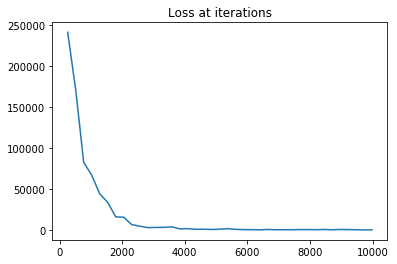

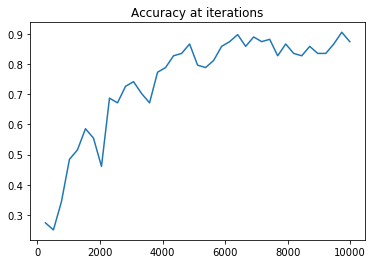

In [17]:
learning_rate = 0.01
training_iters = 10000
batch_size = 128
display_step = 2

n_input = 784 # we unravel the 28x28 image into a row of 784 entries
n_classes = 10 # the end state is the likelihood of falling into 1 of 10 classes
dropout = 0.75 # likelihood that a given entity will be kept

x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

def conv2d(x, W, b, strides=1):
    # Takes in an x, a set of weights, strides over the image, and with 0 pads around the border
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME') 
    # Add in a bias term
    x = tf.nn.bias_add(x, b)
    # ReLU activation
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # Takes the max value over the window to reduce size
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
            strides=[1, k, k, 1],
            padding='SAME')

def conv_net(x, weights, biases, dropout):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2']) # New conv. layer
    conv2 = maxpool2d(conv2, k=2) # new pooling 
    
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])

    fc1 = tf.nn.dropout(fc1, dropout)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

weights = {
        'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
        'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])), # new cv2 weights
        'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
        'out': tf.Variable(tf.random_normal([1024, n_classes]))
        }

biases = {
        'bc1': tf.Variable(tf.random_normal([32])),
        'bc2': tf.Variable(tf.random_normal([64])), # new conv2 weight
        'bd1': tf.Variable(tf.random_normal([1024])), 
        'out': tf.Variable(tf.random_normal([n_classes]))
        }


pred = conv_net(x, weights, biases, keep_prob)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

accuracy_list = []

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})

        if step % display_step == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                y: batch_y, keep_prob: 1.})

            print "Iteration", str(step*batch_size), "and Minibatch Loss= ", \
                    "{:.6f}".format(loss), "and Training Acc.= ", \
                    "{:.5f}".format(acc)
            
            accuracy_list.append((step*batch_size, loss, acc))
        step += 1

    print "Test accuracy:", \
            sess.run(accuracy, feed_dict={x: mnist.test.images,
                y: mnist.test.labels,
                keep_prob: 1.})

    y_actual = tf.argmax(y, 1).eval(feed_dict={y:mnist.test.labels})
    y_pred = tf.argmax(pred, 1).eval(feed_dict={x:mnist.test.images, keep_prob:1.})

    print pd.DataFrame(confusion_matrix(y_actual, y_pred),
            index=['Actually %s' % x for x in range(0, 10)],
            columns=['Predicted %s' %  x for x in range(0, 10)])

    print classification_report(y_actual, y_pred)
    
    plt.plot([x[0] for x in accuracy_list],
         [x[1] for x in accuracy_list],
        )
    plt.title('Loss at iterations')
    plt.show()

    plt.plot([x[0] for x in accuracy_list],
             [x[2] for x in accuracy_list],
            )
    plt.title('Accuracy at iterations')
    plt.show()


This is closer to what we want. The solution seems to perform more smoothly, but, unsurprisingly, takes much longer since there are more layers to compute. 

Let's finally just up the iterations again to see if we can eeke out a little bit more accuracy! The state of the art performance on MNIST digits is 99%+.

Iteration 256 and Minibatch Loss=  197589.593750 and Training Acc.=  0.17969
Iteration 512 and Minibatch Loss=  144228.984375 and Training Acc.=  0.28125
Iteration 768 and Minibatch Loss=  73778.140625 and Training Acc.=  0.33594
Iteration 1024 and Minibatch Loss=  17669.906250 and Training Acc.=  0.56250
Iteration 1280 and Minibatch Loss=  23826.169922 and Training Acc.=  0.57031
Iteration 1536 and Minibatch Loss=  21418.062500 and Training Acc.=  0.57812
Iteration 1792 and Minibatch Loss=  13620.703125 and Training Acc.=  0.69531
Iteration 2048 and Minibatch Loss=  10034.412109 and Training Acc.=  0.68750
Iteration 2304 and Minibatch Loss=  4835.545898 and Training Acc.=  0.81250
Iteration 2560 and Minibatch Loss=  2512.610352 and Training Acc.=  0.86719
Iteration 2816 and Minibatch Loss=  4728.743164 and Training Acc.=  0.78125
Iteration 3072 and Minibatch Loss=  4906.798828 and Training Acc.=  0.76562
Iteration 3328 and Minibatch Loss=  3158.042480 and Training Acc.=  0.82031
Itera

Iteration 27904 and Minibatch Loss=  106.235214 and Training Acc.=  0.94531
Iteration 28160 and Minibatch Loss=  223.685120 and Training Acc.=  0.95312
Iteration 28416 and Minibatch Loss=  116.164124 and Training Acc.=  0.96094
Iteration 28672 and Minibatch Loss=  167.282379 and Training Acc.=  0.95312
Iteration 28928 and Minibatch Loss=  99.258453 and Training Acc.=  0.96875
Iteration 29184 and Minibatch Loss=  298.048248 and Training Acc.=  0.97656
Iteration 29440 and Minibatch Loss=  278.652649 and Training Acc.=  0.93750
Iteration 29696 and Minibatch Loss=  134.418091 and Training Acc.=  0.94531
Iteration 29952 and Minibatch Loss=  264.653229 and Training Acc.=  0.93750
Iteration 30208 and Minibatch Loss=  121.391701 and Training Acc.=  0.93750
Iteration 30464 and Minibatch Loss=  138.240463 and Training Acc.=  0.95312
Iteration 30720 and Minibatch Loss=  170.927948 and Training Acc.=  0.92969
Iteration 30976 and Minibatch Loss=  17.262127 and Training Acc.=  0.98438
Iteration 3123

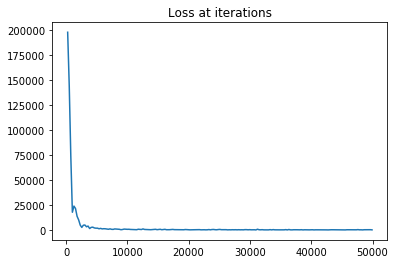

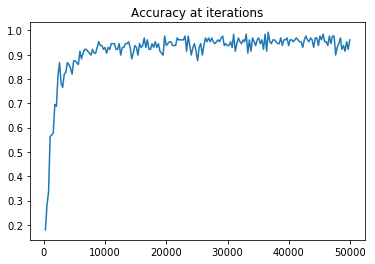

In [18]:
learning_rate = 0.01
training_iters = 50000
batch_size = 128
display_step = 2

n_input = 784 # we unravel the 28x28 image into a row of 784 entries
n_classes = 10 # the end state is the likelihood of falling into 1 of 10 classes
dropout = 0.75 # likelihood that a given entity will be kept

x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

def conv2d(x, W, b, strides=1):
    # Takes in an x, a set of weights, strides over the image, and with 0 pads around the border
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME') 
    # Add in a bias term
    x = tf.nn.bias_add(x, b)
    # ReLU activation
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # Takes the max value over the window to reduce size
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
            strides=[1, k, k, 1],
            padding='SAME')

def conv_net(x, weights, biases, dropout):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2']) # New conv. layer
    conv2 = maxpool2d(conv2, k=2) # new pooling 
    
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])

    fc1 = tf.nn.dropout(fc1, dropout)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

weights = {
        'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
        'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
        'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
        'out': tf.Variable(tf.random_normal([1024, n_classes]))
        }

biases = {
        'bc1': tf.Variable(tf.random_normal([32])),
        'bc2': tf.Variable(tf.random_normal([64])),
        'bd1': tf.Variable(tf.random_normal([1024])), 
        'out': tf.Variable(tf.random_normal([n_classes]))
        }


pred = conv_net(x, weights, biases, keep_prob)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

accuracy_list = []

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})

        if step % display_step == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                y: batch_y, keep_prob: 1.})

            print "Iteration", str(step*batch_size), "and Minibatch Loss= ", \
                    "{:.6f}".format(loss), "and Training Acc.= ", \
                    "{:.5f}".format(acc)
            
            accuracy_list.append((step*batch_size, loss, acc))
        step += 1

    print "Test accuracy:", \
            sess.run(accuracy, feed_dict={x: mnist.test.images,
                y: mnist.test.labels,
                keep_prob: 1.})

    y_actual = tf.argmax(y, 1).eval(feed_dict={y:mnist.test.labels})
    y_pred = tf.argmax(pred, 1).eval(feed_dict={x:mnist.test.images, keep_prob:1.})

    print pd.DataFrame(confusion_matrix(y_actual, y_pred),
            index=['Actually %s' % x for x in range(0, 10)],
            columns=['Predicted %s' %  x for x in range(0, 10)])

    print classification_report(y_actual, y_pred)
    
    plt.plot([x[0] for x in accuracy_list],
         [x[1] for x in accuracy_list],
        )
    plt.title('Loss at iterations')
    plt.show()

    plt.plot([x[0] for x in accuracy_list],
             [x[2] for x in accuracy_list],
            )
    plt.title('Accuracy at iterations')
    plt.show()
